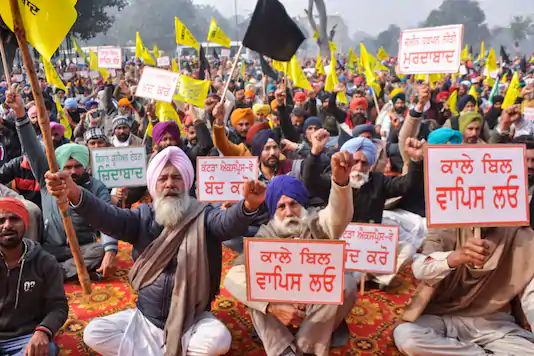

## 0. Setup the environment

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Read the data

In [ ]:
tweets = pd.read_csv("../input/farmers-protest-tweets-dataset-csv/tweets-2021-03-3.csv")

## 2. Print sample data

In [ ]:
tweets.head()

## 3. Get the column names

In [ ]:
tweets.columns

## Subset the data for faster processing, we can then run on the entire data once everything looks fine

In [ ]:
#df2 = df.head(3000)

## 4. Read the users data

In [ ]:
users = pd.read_csv("../input/farmers-protest-tweets-dataset-csv/users-2021-03-3.csv")

## 5. Print sample data

In [ ]:
users.head()

## 6. Merge the datasets

In [ ]:
final =pd.merge(tweets, users, on="userId")

## 7. Print sample data

In [ ]:
final.head()

## We see that a very small percentage of the twitter accounts are verified, let us restrict our analysis to the verified accounts only

In [ ]:
import seaborn as sns
sns.countplot(x="verified",data=final);

In [ ]:
final.columns

In [ ]:
final_verified = final[final["verified"]==True]

In [ ]:
final_verified.shape

In [ ]:
check = final_verified.groupby('username')['tweetId'].count()

In [ ]:
print("Maximum tweets from verified account", check.idxmax(), check.max())

In [ ]:
final_unverified = final[final["verified"]==False]

In [ ]:
check2 = final_unverified.groupby('username')['tweetId'].count()

In [ ]:
print("Maximum tweets from unverified account", check2.idxmax(), check2.max())

# We have almost 13 times more tweets from unverified account compared to verified accounts

In [ ]:
check3 = final_verified.groupby('location')['tweetId'].count()

In [ ]:
print("Maximum verified tweets from location", check3.idxmax(), check3.max())

In [ ]:
check4 = final_unverified.groupby('location')['tweetId'].count()

In [ ]:
print("Maximum unverified tweets from location", check4.idxmax(), check4.max())

# We have almost 6 times more tweets from unverified account in India compared to verified accounts

## 8. Sentiment analysis using LSTM

### 8.1 Read in sample data with sentiment marked

In [ ]:
data = pd.read_csv( "../input/twitter-sentiment/Sentiment.csv")
# Keeping only the neccessary columns
data = data[['text','sentiment']]
data.head()

In [ ]:
#sns.countplot(x="id",data=data);

## 8.2 Data preprocessing for model

In [ ]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
vocabSize = 2000
tokenizer = Tokenizer(num_words=vocabSize, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

## 8.3 Define the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(vocabSize, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

## 8.4 Train the LSTM model

In [ ]:
from sklearn.model_selection import train_test_split

Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

## 8.5 Fit the model

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
import numpy as np

pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0

for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_test[x]):
        if np.argmax(Y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

## 8.6 Analyse sentiment of a sample tweet

In [ ]:
twt = ['Punjab’s lions and Bengals tigers fighting together again. History repeats itself.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

## Next steps - Run the analysis on all the tweets